In [1]:
import numpy as np
from scipy.stats import truncnorm, norm, binom, rv_continuous
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns

# Constants & Assumptions

In [2]:
cutoff = 0.95 # The European norm for the required accuracy of the machine

In [3]:
price = 119000 # in €, price of machine

In [4]:
cost_of_failing = price / 10 # Price company has to pay of delivering a machine that doesn't satisfy European norm

In [5]:
# cost_of_failing = 0

# Classes

In [6]:
class Wafer:
    pass

In [7]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [8]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        """Make machine with probability p of turning a wafer into a working cell."""
        self.p = p
    
    def deposit(self, wafer):
        """Deposit a Wafer, returns a SolarCell"""
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        """Diagnose a SolarCell, returns whether the cell works"""
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        """Test the machine n times and return the ratio of working cells"""
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        """Pretty print the status of machine."""
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        """Reset the machine."""
        self.runtime = 0
        self.costs = 0
        
    def plot_pmf(self, n):
        """Plot the probability of each estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()
        
    def plot_cdf(self, n):
        """Plot cdf of estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.cdf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.cdf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("cumulative density function")
        plt.show()

    # Testing with variable number of tests
    def test_advanced_95(self, min_tests, max_tests):
        """Test the machine until it is 95% certain that the machine works or we reached the maximum number of tests.
        Maximum number of tests is given by max_tests.
        """
        successes = 0
        p_ = 1
        
        if max_tests < min_tests:
            min_tests = max_tests + 1

        for n in range(1, min_tests):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
        
        for n in range(min_tests + 1, max_tests + 1):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = Machine.wilson_score_interval_95(p_, n)
            
            if (left > cutoff and right > cutoff):
                return (p_, n)
            
            if (left < cutoff and right < cutoff):
                return (p_, n)
                   
        return (p_, n)
    
    def calculate_interval(certainty, p_, n):
        """Incorrect implementation, use wilson_score_interval_95 instead"""
        error = (1 - certainty) / 2
        
        # Bounds expressed in successes
        leftS = binom.ppf(error, n, p_)
        rightS = binom.ppf(1 - error, n, p_)
        
        # Express in p_
        return (leftS / n, rightS / n)

    
    def wilson_score_interval_95(p_, n):
        """Returns (the Wilson approximation of) the interval such that it is 95% certain that after n tests
        the actual probability of the machine lies in this interval"""
        # From https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
        z = 1.96 # for 95% confidence
        
        base = (p_ + z**2/(2*n))/(1+z**2/n)
        spread = z/(1+z**2/n) * math.sqrt((p_*(1-p_))/n + z**2/(4*n**2))
        
        left = base - spread
        right = base + spread
        
        return (left, right)
        
    def procedure_basic(self, n):
        """This basic procedure uses the test_basic to approximate the accuracy of the machine.
        The basic test takes n wafers and returns the ratio (=p_) of working wafers"""
        return self.test_basic(n) >= cutoff
    
    def procedure_advanced_95(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(min_tests, max_tests)
        return p_ >= cutoff
    
    def procedure_advanced_95_true(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(min_tests, max_tests)
        if n == max_tests:
            return True
        else: return p_ >= cutoff
        
    def procedure_advanced_95_false(self, min_tests, max_tests):
        """This procedure uses test_advanced to approximate the accuracy of the machine."""
        (p_, n) = self.test_advanced_95(min_tests, max_tests)
        if n == max_tests:
            return False
        else: return p_ >= cutoff
    
    def procedure_trivial(self):
        # This testing procedure basically doesn't test, but accepts all machines
        # Used for cost computation purposes
        return True


In [9]:
class double_trunc_norm_gen(rv_continuous):
    # Doesn't work for generating rvs, but still useful for plotting
    "Double truncated normal"
    def _pdf(self, x, mu1, sigma1, mu2, sigma2, step):
        return step * truncnorm.pdf(x, -mu1 / sigma1, (1 - mu1) / sigma1, loc=mu1, scale=sigma1) \
             + (1-step) * truncnorm.pdf(x, -mu2 / sigma2, (1 - mu2) / sigma2, loc=mu2, scale=sigma2)

In [10]:
double_trunc_norm = double_trunc_norm_gen(name="double truncated normal")

## Factory

In [74]:
class Factory:
    def __init__(self, mu, sigma):
        """Factory that makes a machine with accuracies normally distributed."""
        self.mu = mu
        self.sigma = sigma
        
    def makeMachines(self, n):
        """Make machine"""
        ps = truncnorm(-self.mu / self.sigma, (1 - self.mu) / self.sigma, loc=self.mu, scale=self.sigma).rvs(n)
        return list(map(Machine, ps))
    
    def makeMachine(self):
        return self.makeMachines(1)[0]
    
    def test_testing_procedure(self, procedure, n, **kwargs): #onhandige naam maarja...
        """Test a procedure on machines normally distributed with mu sigma (truncated) n times.
        Procedure is a function that takes a machine and returns whether the machine works correctly."""
        successes = 0
        costs = 0
        time = 0
        
        machines = kwargs.get('batch', self.makeMachines(n))
#         machines = self.makeMachines(n)

        for m in machines:
            # if procedure gives correct result
            if procedure(m) == (m.p >= cutoff):
                successes += 1

            costs += m.costs
            time += m.runtime
            
            m.reset()

        costs /= n
        time /= n
        accuracy = successes / n
        
        total_costs = costs + (1 - accuracy) * cost_of_failing
        
        return (total_costs, costs, time, accuracy)
    
    def print_testing_procedure(self, procedure, n):
        (total_costs, costs, time, accuracy) = self.test_testing_procedure(procedure, n)
        
        print(f"Testing procedure was accurate {accuracy * 100}% of the time.")

        days = time // (24 * 60)
        hours = (time % (24 * 60)) // 60
        minutes = (time % (24 * 60)) % 60
        rcosts = round(costs, 2)
        
        r_total_costs = round(total_costs, 2)

        print("Test procedure took on average ", days, "day(s),", hours, "hour(s) and", minutes, "minute(s).")
        print("The costs associated with this test procedure is on average €" + str(rcosts))
        print(f"Total costs is on average € {r_total_costs}")
    
    def compare_testing_procedures(self, procedure1, procedure2, n, **kwargs):
        """Get two procedures and return the name, min_costs and min_time of the cheapest one"""
        batch = kwargs.get('batch', None)
        if batch:
            (total_costs1, costs1, time1, accuracy1) = self.test_testing_procedure(procedure1, n, batch=batch)
            (total_costs2, costs2, time2, accuracy2) = self.test_testing_procedure(procedure2, n, batch=batch)
        else:
            (total_costs1, costs1, time1, accuracy1) = self.test_testing_procedure(procedure1, n)
            (total_costs2, costs2, time2, accuracy2) = self.test_testing_procedure(procedure2, n)

        if total_costs1 < total_costs2:
            min_total_costs = total_costs1
            costs = costs1
            time = time1
            name = procedure1.__name__
            accuracy = accuracy1
        else:
            min_total_costs = total_costs2
            costs = costs2
            time = time2
            name = procedure2.__name__
            accuracy = accuracy2
        return (name, min_total_costs, costs, time, accuracy)
    
    def compare_list_testing_procedures(self, procedures, n, **kwargs):
        batch = kwargs.get('batch', None)
        name = ""
        min_total_costs = 999999999999999
        for i in range(len(procedures)-1):
            print(procedures[i].__name__)
            print(procedures[i+1].__name__)
            if batch:
                (name_, min_total_costs_, costs_, time_, accuracy_) = self.compare_testing_procedures(procedures[i], procedures[i+1], n, batch=batch)
            else:
                (name_, min_total_costs_, costs_, time_, accuracy_) = self.compare_testing_procedures(procedures[i], procedures[i+1], n)
            print(name_, min_total_costs_, costs_, time_, accuracy_)
            print()
            if min_total_costs_ < min_total_costs:
                min_total_costs = min_total_costs_
                time = time_
                costs = costs_
                accuracy = accuracy_
                name = name_
        return (name, min_total_costs, costs, time, accuracy)
    
    def plot(self, x):
        fig, ax = plt.subplots(1, 1)
        ax.plot(x, truncnorm.pdf(x, -self.mu / self.sigma, (1 - self.mu) / self.sigma, loc=self.mu, scale=self.sigma))
        ax.set_xlabel("machine accuracy")
        ax.set_ylabel("probability density function")
        ax.set_title(f"PDF of factory with $\mu={self.mu}$, $\sigma$={self.sigma}")
        plt.show()
        return ax

In [83]:
class AltFactory(Factory):
    def __init__(self, mu1, sigma1, mu2, sigma2, step):
        """Factory that makes a machine with accuracies taken from two normal distributions, truncated between 0 and 1.
        With probability step from a truncated normal distribution around mu1 with deviation sigma1.
        With probability 1-step from a truncated normal distribution around mu2 with deviation sigma2.
        """
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.step = step
        
    def makeMachines(self, n):
        """Make machine"""
        if random.random() < self.step:
            mu = self.mu1
            sigma = self.sigma1
        else:
            mu = self.mu2
            sigma = self.sigma2
        ps = truncnorm(-mu / sigma, (1 - mu) / sigma, loc=mu, scale=sigma).rvs(n)
        return map(Machine, ps)
    
    def plot(self, x):
        fig, ax = plt.subplots(1, 1)
        ax.plot(x, double_trunc_norm.pdf(x, self.mu1, self.sigma1, self.mu2, self.sigma2, self.step))
        ax.set_xlabel("machine accuracy")
        ax.set_ylabel("probability density function")
        ax.set_title(f"PDF of alternative factory with $\mu_1={self.mu1}$, $\mu_2={self.mu2}$, \n$\sigma_1$={self.sigma1}, $\sigma_2$={self.sigma2}, step={self.step}")
        plt.show()
        return ax

# Factories

In [84]:
f = Factory(0.98, 0.05)
alt_f = AltFactory(0.98, 0.05, 0.3, 0.2, 0.98)

# Plots

In [70]:
sns.set(font_scale=1.3)

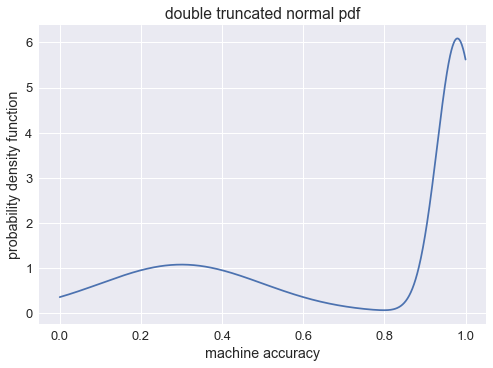

In [71]:
mu1 = 0.98
sigma1 = 0.05
mu2 = 0.3
sigma2 = 0.2

fig, ax = plt.subplots(1, 1)
x = np.arange(0, 1.001, 0.001)
ax.plot(x, double_trunc_norm.pdf(x, mu1, sigma1, mu2, sigma2, 0.5))
ax.set_xlabel("machine accuracy")
ax.set_ylabel("probability density function")
ax.set_title('double truncated normal pdf')
plt.show()

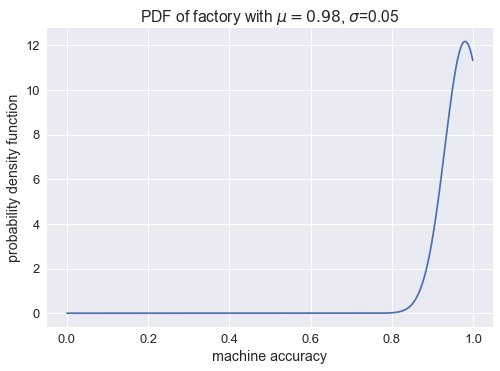

In [73]:
ax = f.plot(np.arange(0, 1, 0.001))
ax.get_figure().savefig("factory_pdf.pdf")

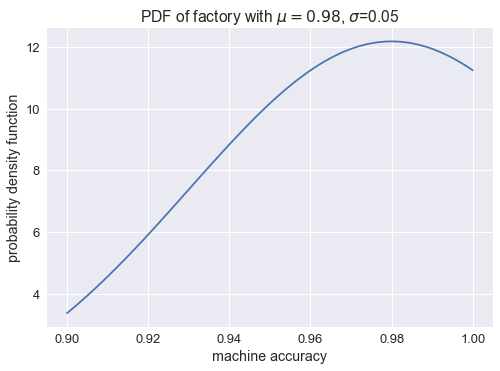

In [57]:
f.plot(np.arange(0.9, 1.001, 0.001))

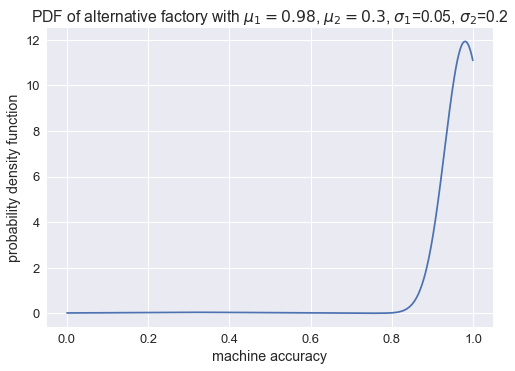

In [58]:
alt_f.plot(np.arange(0, 1, 0.001))

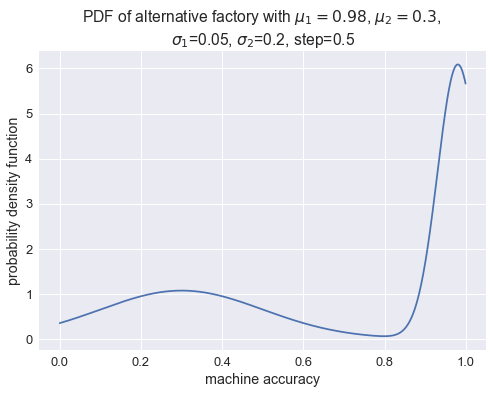

In [86]:
ax = AltFactory(0.98, 0.05, 0.3, 0.2, 0.5).plot(np.arange(0, 1, 0.001))
ax.get_figure().savefig("alt_factory_pdf.pdf")

# Proper Testing

In [19]:
def basic(n):
    f = lambda m : m.procedure_basic(n)
    f.__name__ = f"Basic({n})"
    return f

In [20]:
def advanced(min_n, max_n):
    f = lambda m : m.procedure_advanced_95(min_n, max_n)
    f.__name__ = f"Advanced({min_n}, {max_n})"
    return f

In [21]:
def advanced_true(min_n, max_n):
    f = lambda m : m.procedure_advanced_95_true(min_n, max_n)
    f.__name__ = f"Advanced True ({min_n}, {max_n})"
    return f

In [22]:
def advanced_false(min_n, max_n):
    f = lambda m : m.procedure_advanced_95_false(min_n, max_n)
    f.__name__ = f"Advanced False ({min_n}, {max_n})"
    return f

In [23]:
def test_basic_vs_advanced(factory):
    ns = range(100, 400, 10)
    procedures = list(map(basic, ns)) + list(map(lambda max_n: advanced(50, max_n), ns))
    (name, min_total_costs, costs, time, accuracy) = factory.compare_list_testing_procedures(procedures, 2000)
    print(f"Test with minimal cost is {name}, with total_costs €{min_total_costs}, costs €{costs}, time {time} and accuracy {accuracy}")

In [24]:
batch = f.makeMachines(2500)

In [25]:
def test_advanced_tests(factory, advanced_procedure):
    min_ns = range(0, 100, 25)
    max_ns = range(100, 1500, 50)
    procedures = []
    for min_n in min_ns:
        for max_n in max_ns:
            procedures.append(advanced_procedure(min_n, max_n))
    (name, min_total_costs, costs, time, accuracy) = factory.compare_list_testing_procedures(procedures, 2500, batch=batch)
    print(f"Test with minimal cost is {name}, with total_costs €{min_total_costs}, costs €{costs}, time {time} and accuracy {accuracy}")

In [26]:
test_advanced_tests(f, advanced)

Advanced(0, 100)
Advanced(0, 150)
Advanced(0, 150) 2514.663222857143 425.02322285714297 1046.1268 0.8244

Advanced(0, 150)
Advanced(0, 200)
Advanced(0, 200) 2396.559542857143 516.3595428571425 1271.084 0.842

Advanced(0, 200)
Advanced(0, 250)
Advanced(0, 250) 2288.152537142856 588.8325371428558 1449.534 0.8572

Advanced(0, 250)
Advanced(0, 300)
Advanced(0, 250) 2231.8684342857123 584.9084342857128 1439.9308 0.8616

Advanced(0, 300)
Advanced(0, 350)
Advanced(0, 350) 2149.912914285714 721.9129142857141 1777.2312 0.88

Advanced(0, 350)
Advanced(0, 400)
Advanced(0, 350) 2268.4387428571417 711.9187428571414 1752.708 0.8692

Advanced(0, 400)
Advanced(0, 450)
Advanced(0, 400) 2226.353908571419 779.313908571419 1918.7364 0.8784

Advanced(0, 450)
Advanced(0, 500)
Advanced(0, 450) 2228.543417142852 791.0234171428516 1947.5112 0.8792

Advanced(0, 500)
Advanced(0, 550)
Advanced(0, 500) 2240.725908571419 860.3259085714191 2118.2068 0.884

Advanced(0, 550)
Advanced(0, 600)
Advanced(0, 550) 2254.9334

Advanced(50, 1150) 2330.068285714313 1616.0682857143122 3978.888 0.94

Advanced(50, 1150)
Advanced(50, 1200)
Advanced(50, 1150) 2369.9540457143157 1560.7540457143161 3842.7808 0.932

Advanced(50, 1200)
Advanced(50, 1250)
Advanced(50, 1200) 2458.899188571471 1697.2991885714714 4178.952 0.936

Advanced(50, 1250)
Advanced(50, 1300)
Advanced(50, 1300) 2533.474480000038 1724.2744800000385 4245.4052 0.932

Advanced(50, 1300)
Advanced(50, 1350)
Advanced(50, 1300) 2476.1284000000423 1724.0484000000422 4244.8252 0.9368

Advanced(50, 1350)
Advanced(50, 1400)
Advanced(50, 1400) 2599.2003657143105 1813.8003657143113 4465.9172 0.934

Advanced(50, 1400)
Advanced(50, 1450)
Advanced(50, 1400) 2616.633885714313 1835.993885714313 4520.7152 0.9344

Advanced(50, 1450)
Advanced(75, 100)
Advanced(75, 100) 2364.463828571434 422.3838285714339 1040.1224 0.8368

Advanced(75, 100)
Advanced(75, 150)
Advanced(75, 100) 2359.29652571429 421.9765257142908 1039.028 0.8372

Advanced(75, 150)
Advanced(75, 200)
Advanced(

In [31]:
test_advanced_tests(f, advanced_false)

Advanced False (0, 100)
Advanced False (0, 150)
Advanced False (0, 150) 4310.658125714286 426.49812571428583 1049.866 0.6736

Advanced False (0, 150)
Advanced False (0, 200)
Advanced False (0, 200) 4052.477931428571 515.7979314285708 1269.7244 0.7028

Advanced False (0, 200)
Advanced False (0, 250)
Advanced False (0, 250) 3589.3276571428555 581.0076571428555 1430.2796 0.7472

Advanced False (0, 250)
Advanced False (0, 300)
Advanced False (0, 300) 3355.395314285717 656.4753142857172 1616.1332 0.7732

Advanced False (0, 300)
Advanced False (0, 350)
Advanced False (0, 350) 3120.209119999999 702.1291199999986 1728.538 0.7968

Advanced False (0, 350)
Advanced False (0, 400)
Advanced False (0, 350) 3208.3655885714265 676.0455885714268 1664.3932 0.7872

Advanced False (0, 400)
Advanced False (0, 450)
Advanced False (0, 450) 3159.918708571422 817.9987085714224 2013.9252 0.8032

Advanced False (0, 450)
Advanced False (0, 500)
Advanced False (0, 450) 3090.4222057142806 815.1422057142801 2006.938

Advanced False (50, 500) 3374.323897142865 1080.0038971428653 2658.62 0.8072

Advanced False (50, 550)
Advanced False (50, 600)
Advanced False (50, 600) 3345.6725257142975 1189.3925257142973 2928.0392 0.8188

Advanced False (50, 600)
Advanced False (50, 650)
Advanced False (50, 650) 3274.076000000002 1241.556000000002 3056.612 0.8292

Advanced False (50, 650)
Advanced False (50, 700)
Advanced False (50, 700) 3169.723954285737 1280.0039542857364 3151.2624 0.8412

Advanced False (50, 700)
Advanced False (50, 750)
Advanced False (50, 700) 3135.467817142879 1288.587817142879 3172.4064 0.8448

Advanced False (50, 750)
Advanced False (50, 800)
Advanced False (50, 750) 3145.8741942857478 1289.4741942857477 3174.6116 0.844

Advanced False (50, 800)
Advanced False (50, 850)
Advanced False (50, 800) 3097.0735885714384 1354.913588571439 3335.6788 0.8536

Advanced False (50, 850)
Advanced False (50, 900)
Advanced False (50, 900) 3172.9211657143023 1492.6411657143024 3675.07 0.8588

Advanced False 

In [32]:
test_advanced_tests(f, advanced_true)

Advanced True (0, 100)
Advanced True (0, 150)
Advanced True (0, 150) 3110.4186171428573 425.77861714285723 1048.0576 0.7744

Advanced True (0, 150)
Advanced True (0, 200)
Advanced True (0, 200) 2920.772708571429 507.45270857142935 1249.2236 0.7972

Advanced True (0, 200)
Advanced True (0, 250)
Advanced True (0, 200) 2838.6038857142853 506.20388571428555 1246.1172 0.804

Advanced True (0, 250)
Advanced True (0, 300)
Advanced True (0, 300) 2840.088262857148 660.0082628571475 1624.834 0.8168

Advanced True (0, 300)
Advanced True (0, 350)
Advanced True (0, 350) 2842.482445714284 710.0024457142837 1748.0628 0.8208

Advanced True (0, 350)
Advanced True (0, 400)
Advanced True (0, 400) 2743.239211428563 763.079211428563 1878.6536 0.8336

Advanced True (0, 400)
Advanced True (0, 450)
Advanced True (0, 400) 2790.4514057142783 757.9314057142789 1865.968 0.8292

Advanced True (0, 450)
Advanced True (0, 500)
Advanced True (0, 500) 2765.0490057142774 861.0490057142769 2119.9912 0.84

Advanced True (

Advanced True (50, 550) 2494.265782857139 1151.9457828571387 2835.8216 0.8872

Advanced True (50, 600)
Advanced True (50, 650)
Advanced True (50, 600) 2531.7726971428647 1208.4926971428654 2975.1232 0.8888

Advanced True (50, 650)
Advanced True (50, 700)
Advanced True (50, 650) 2637.52298285715 1252.3629828571504 3083.1316 0.8836

Advanced True (50, 700)
Advanced True (50, 750)
Advanced True (50, 700) 2622.8362857143047 1299.5562857143054 3199.4996 0.8888

Advanced True (50, 750)
Advanced True (50, 800)
Advanced True (50, 750) 2568.9233942857454 1317.0433942857462 3242.3968 0.8948

Advanced True (50, 800)
Advanced True (50, 850)
Advanced True (50, 800) 2648.5741257142936 1372.894125714294 3379.9804 0.8928

Advanced True (50, 850)
Advanced True (50, 900)
Advanced True (50, 850) 2622.9463542857425 1418.666354285743 3492.7772 0.8988

Advanced True (50, 900)
Advanced True (50, 950)
Advanced True (50, 900) 2522.8316914285924 1447.0716914285922 3562.6984 0.9096

Advanced True (50, 950)
Advan

Test with minimal cost is Advanced(50, 200), with total_costs €2044.945171428528, costs €647.8851714285286, time 1594.7338 and accuracy 0.8826

In [88]:
runtime = 2036.4416
days = runtime // (24 * 60)
hours = (runtime % (24 * 60)) // 60
minutes = (runtime % (24 * 60)) % 60
days, hours, minutes

(1.0, 9.0, 56.44160000000011)

In [37]:
f.test_testing_procedure(Machine.procedure_trivial, 100)

(5354.999999999999, 0.0, 0.0, 0.55)